<a href="https://colab.research.google.com/github/rodriquiel/DeteccionFraudeTarjetas/blob/main/DeteccionFraudesTarjetas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteccion de fraude con tarjeta de credito

El dataset utilizado incluye informacion sobre transacciones realizadas con tarjetas de credito en el año 2013 por usuarios europeos. El objetivo es entrenar un modelo de clasificacion para detectar si una transaccion es legitima o no. Una transaccion pertenece a la categoria positiva (1) si se trata de un fraude y a la negativa (0) en el caso contrario.

Se tiene acceso a una cantidad de transacciones realizadas en un determinado periodo de tiempo, donde la mayoria de las transacciones son legitimas y solo una pequeña franccion no lo son. Para ponerlo en numeros, del dataset utilizado solo 492 transacciones de 284.807 son fraudulentas, dando un pocentaje de tan solo 0,172%.

Librerias utilizadas para el modelado: Scikit-Learn, SnapML, Numpy, Pandas, Matplotlib

## Import librerias

In [1]:
!pip install snapml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.8 MB/s eta 0:00:00


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

## Descarga dataset

In [3]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"

data=pd.read_csv(url)

## Analisis dataset

Cada fila del dataset representa una transaccion realizada, y cada columna representa una variable referida a las transacciones. Una de las variables, llamada 'Class' representa si se trata de una transaccion fraudulenta (1) o una legitima (0), por lo tanto dicha variable es la cual se busca predecir mediante la informacion brindada por las demas. La naturaleza de los valores de la variable a predecir indican que se trata de un problema de clasificacion binaria.


Por cuestiones de confidencialidad, el nombre original de cada variable, exceptuando 'Amount', fue reemplazado por un nombre generico (Vn) dependiendo de su posicion en el dataset.

In [4]:
print("Cantidad de tansacciones: " + str(len(data)))
print("Cantidad de variables: " + str(len(data.columns)))

data.head()

Cantidad de tansacciones: 284807
Cantidad de variables: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


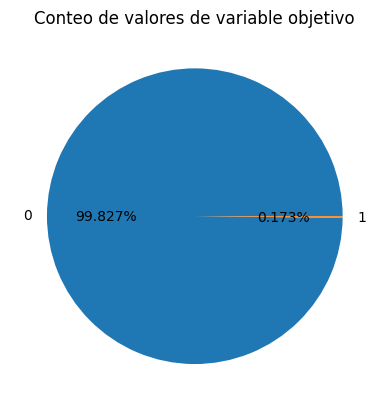

In [5]:
labels = data.Class.unique()
sizes = data.Class.value_counts().values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Conteo de valores de variable objetivo')
plt.show()

El grafico permite ver que el dataset se encuentra desequilibrado en cuanto a las clases de la variable objetivo, las cuales no estan representadas por igual, por lo que este caso requiere prestar atencion a la hora del entrenamiento del modelo o de la evaluacion de su calidad. Una forma de abordar este caso es sesgar el modelo para que preste más atención a las muestras de la clase minoritaria.

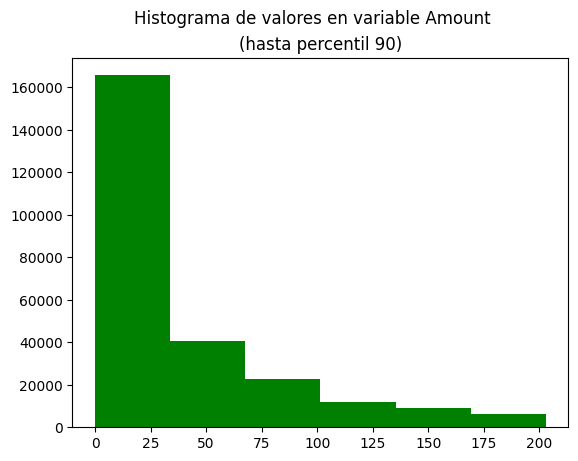

Valor minimo:  0.0
Valor maximo:  25691.16
Media:  88.34961925093133
Mediana:  22.0
90% tienen un valor menor o igual a  203.0


In [6]:
plt.hist(data.Amount, 6, histtype='bar', facecolor='g', range=(np.min(data.Amount.values),np.percentile(data.Amount.values, 90)))
plt.suptitle("Histograma de valores en variable Amount")
plt.title("(hasta percentil 90)")
plt.show()

print("Valor minimo: ", np.min(data.Amount.values))
print("Valor maximo: ", np.max(data.Amount.values))
print("Media: ", np.mean(data.Amount.values))
print("Mediana: ", np.median(data.Amount.values))
print("90% tienen un valor menor o igual a ", np.percentile(data.Amount.values, 90))

En el histograma se puede observar donde se acumulan la mayor cantidad de valores en cuanto a la varable 'Amount', y algunos otros datos estadisticos como la media, la mediana y el maximo.

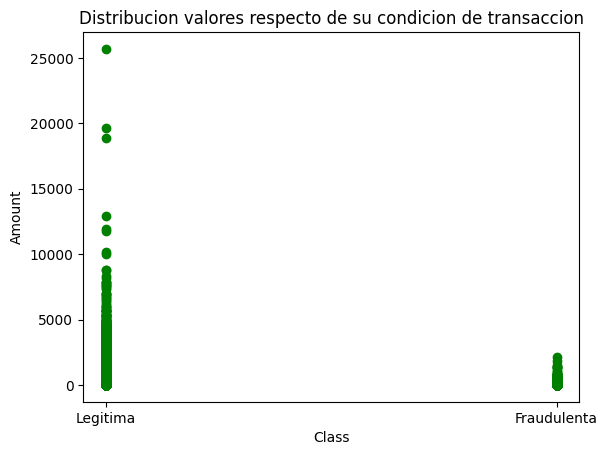

In [7]:
plt.scatter(data.Class, data.Amount,  color='green')
plt.xticks([0, 1], ['Legitima', 'Fraudulenta'])
plt.xlabel("Class")
plt.ylabel("Amount")
plt.title("Distribucion valores respecto de su condicion de transaccion")
plt.show();

Este grafico permite ver que las transacciones fraudulentas son sobre valores que no superan los 2500 en cuanto a la variable 'Amount', por lo que se puede suponer que cuando se trata de transacciones con valores por encima de dicho valor se puede afirmar que la transaccion es legitima

## Preprocesamiento de datos

Durante el preprocesamientod de datos, es util el escalado o la normalizacion para modelos lineales para acelerar la convergencia del entrenamiento.
Se pueden estandarizar características eliminando la media y escalando a la varianza unitaria.

In [8]:
data.iloc[:, 1:30] = StandardScaler().fit_transform(data.iloc[:, 1:30])
data_matrix = data.values

# X: matriz de caracteristicas (se excluye la variable Time para este analisis)
X = data_matrix[:, 1:30]

# y: vector de categoria
y = data_matrix[:, 30]

# normalizacion de datos
X = normalize(X, norm="l1")

print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (284807, 29) y.shape= (284807,)


In [12]:
np.unique(y)

array([0., 1.])

## Train y Test Split

El dataset se tiene que dividir en dos partes antes de construir el modelo de clasificacion: un subset a utilizar para entrenar el modelo y el otro para evaluar la calidad y el rendimiento del modelo entrenado

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (199364, 29) Y_train.shape= (199364,)
X_test.shape= (85443, 29) Y_test.shape= (85443,)


In [14]:
# calcular los pesos de muestra que se utilizarán como entrada para la rutina del tren de modo que
# tiene en cuenta el desequilibrio de clases presente en este conjunto de datos
w_train = compute_sample_weight('balanced', y_train)

## Construccion de Arbol de Decision

#### Prueba de hiperparametros para Arbol de Decision de SciKit-Learn


In [34]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

In [50]:
def iniciar_arbol_decision(profundidad, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth = profundidad, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, X, y, return_train_score=True)
  test_score = results['test_score'].mean()*100
  train_score = results['train_score'].mean()*100
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  print('Profundidad = %d, min_samples_leaf = %d, min_samples_split = %d, testing = %.2f, training = %.2f' % (profundidad,min_samples_leaf,min_samples_split,test_score,train_score))
  tabla = [profundidad, min_samples_leaf, min_samples_split, test_score, train_score, score_time, fit_time]
  return tabla

In [54]:
def buscar():
  resultados = []
  for profundidad in range(1,5):
    for min_samples_leaf in [32,64,128,256]:
      for min_samples_split in [32,64,128,256]:
        tabla = iniciar_arbol_decision(profundidad,min_samples_leaf,min_samples_split)
        resultados.append(tabla)
  resultados = pd.DataFrame(resultados, columns=['max_depth','min_samples_leaf','min_samples_split','testing','training','score_time','fit_time'])
  return resultados

In [55]:
resultados = buscar()
resultados.head(10)

Profundidad = 1, min_samples_leaf = 32, min_samples_split = 32, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 64, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 128, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 256, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 32, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 64, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 128, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 256, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 128, min_samples_split = 32, testing = 99.86, training = 99.86
Profundidad = 1, min_samples_leaf = 128, min_samples_split = 64, testing = 99.86, training = 99.86
Profundidad = 

,max_depth,min_samples_leaf,min_samples_split,testing,training,score_time,fit_time
0,1,32,32,99.857096,99.859642,0.010628,1.463569
1,1,32,64,99.857096,99.859642,0.011867,1.565728
2,1,32,128,99.857096,99.859642,0.011973,1.527173
3,1,32,256,99.857096,99.859642,0.011268,1.471441
4,1,64,32,99.857096,99.859642,0.011840,1.569260
5,1,64,64,99.857096,99.859642,0.011792,1.470775
6,1,64,128,99.857096,99.859642,0.011135,1.530480
7,1,64,256,99.857096,99.859642,0.011617,1.562962
8,1,128,32,99.857096,99.859642,0.011062,1.449469
9,1,128,64,99.857096,99.859642,0.011670,1.562881


In [56]:
resultados.sort_values('testing', ascending = False).head()

,max_depth,min_samples_leaf,min_samples_split,testing,training,score_time,fit_time
19,2,32,256,99.867279,99.870702,0.011059,2.930531
35,3,32,256,99.867279,99.870702,0.012072,4.451113
16,2,32,32,99.862714,99.874828,0.012301,2.922613
34,3,32,128,99.862714,99.874828,0.011912,4.439277
18,2,32,128,99.862714,99.874828,0.010787,3.057672


In [57]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,testing,training,score_time,fit_time
max_depth,1.000000e+00,1.014371e-16,1.690619e-17,-0.022380,0.189417,0.090046,0.999138
min_samples_leaf,1.014371e-16,1.000000e+00,-2.059544e-17,-0.883755,-0.938771,0.161046,0.001108
min_samples_split,1.690619e-17,-2.059544e-17,1.000000e+00,0.069989,-0.034689,-0.033621,0.004303
testing,-2.238006e-02,-8.837546e-01,6.998941e-02,1.000000,0.872087,-0.136391,-0.023253
training,1.894166e-01,-9.387708e-01,-3.468875e-02,0.872087,1.000000,-0.117504,0.188480
score_time,9.004613e-02,1.610460e-01,-3.362088e-02,-0.136391,-0.117504,1.000000,0.103203
fit_time,9.991385e-01,1.108462e-03,4.302540e-03,-0.023253,0.188480,0.103203,1.000000


### Arbol de Decision con SciKit-Learn

In [62]:
from sklearn.tree import DecisionTreeClassifier

skl_dt = DecisionTreeClassifier(max_depth=4, random_state=35, min_samples_leaf=32, min_samples_split=256)

t0_skl = time.time()
skl_dt.fit(X_train, y_train, sample_weight=w_train)

#Calcula el tiempo que tarda el modelo en entrenarse
skl_time = time.time()-t0_skl
print("Tiempo entrenamiento SciKit-Learn (s):  {0:.5f}".format(skl_time))

Tiempo entrenamiento SciKit-Learn (s):  8.28475


### Arbol de Decision con Snap ML

In [ ]:
from snapml import DecisionTreeClassifier

snapml_dt = DecisionTreeClassifier(max_depth=5, random_state=45, use_gpu=True, n_jobs=4)

t0_snapml = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)

#Calcula el tiempo que tarda el modelo en entrenarse
snapml_time = time.time()-t0_snapml
print("Tiempo entrenamiento Snap ML (s):  {0:.5f}".format(snapml_time))

Tiempo entrenamiento Snap ML (s):  0.74628


## Evaluacion de los modelos entrenados

Comparacion de los tiempos de entrenamiento de los modelos con SciKit-Learn y Snap ML

In [ ]:
training_speedup = skl_time/snapml_time
print('[Arbol de decision] mejora de tiempo Snap ML vs. Scikit-Learn: {0:.2f}x '.format(training_speedup))


[Arbol de decision] mejora de tiempo Snap ML vs. Scikit-Learn: 9.63x 


Se puede ver que hay una mejoria en el tiempode  entrenamiento de los modelos al utilizar Snap ML en vez de SciKit-Learn (6.50 veces mas rapido), esto se debe a que Snap Ml utiliza CPU/GPU para poder acelerar el entrenamiento de los modelos.
Para este caso ambos tiempos de entrenamiento resultan buenos (menos de 10 segundos) pero para dataset de mayor tamaño puede resultar de mucha conveniencia el uso de Snap ML

In [63]:
# calcular las probabilidades de que las muestras de prueba
# pertenezcan a la clase de transacciones fraudulentas
skl_pred = skl_dt.predict_proba(X_test)[:,1]

# Clasificación Curva ROC y AUC
skl_roc_auc = roc_auc_score(y_test, skl_pred)
print('Scikit-Learn ROC-AUC score : {0:.3f}'.format(skl_roc_auc))


Scikit-Learn ROC-AUC score : 0.937


In [ ]:
# calcular las probabilidades de que las muestras de prueba
# pertenezcan a la clase de transacciones fraudulentas
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

# Clasificación Curva ROC y AUC
snapml_roc_auc = roc_auc_score(y_test, snapml_pred)
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Snap ML] ROC-AUC score : 0.900


Una curva ROC representa TPR (Tasa de verdaderos positivos) frente a FPR (Tasa de falsos positivos) en diferentes umbrales de clasificación. Al disminuir el umbral de clasificación, se clasifican más elementos como positivos, lo que aumenta tanto los falsos positivos como los verdaderos positivos.
AUC significa "área bajo la curva ROC". Es decir, el AUC mide el área bidimensional completa debajo de la curva ROC completa.
Una forma de interpretar el AUC es como la probabilidad de que el modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio. El AUC varía en valor de 0 a 1. Un modelo cuyas predicciones son un 100% incorrectas tiene un AUC de 0.0; uno cuyas predicciones son un 100% correctas tiene un AUC de 1.0.


####Otras metricas de evaluacion de los modelos

Definicion funciones a utilizar

In [64]:
# Métricas y desempeño
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Grafica Matrix de confusión

**Definicion de metricas de tabla de reporte**

Precision: proporción de predicciones positivas que fueron correctas (cuántos casos que el modelo predijo como positivos, realmente eran positivos).

Recall: proporción de casos reales positivos que fueron correctamente identificados (de todos los casos positivos reales, cuantos fueron identificados).

F1-score: media armónica de precision y recall. Resume precisión y sensibilidad de un modelo en una sola métrica.

Support: número de muestras de cada clase que se usaron para calcular las métricas.

Macro avg: Promedio simple de métricas por clase. No considera tamaños.

Weighted avg: Promedio ponderado por clase. Considera tamaños de clase.

In [18]:
def plot_confusion_matrix(y_true, y_preds, labels=None, model_name=None, normalize=None):
    """
    Función para graficar la Matrix de confusión
    y_true: vector de salida real
    y_predic: vector de salida predicho por el modelo
    labels: opcional, para nombrar las clases. Lista con strings
    model_name: opcional, para poner un título al gráfico
    normalize: {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    """
    if normalize:
        cm = confusion_matrix(y_true, y_preds, normalize=normalize)
    else:
        cm = confusion_matrix(y_true, y_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    cmd.plot()
    cmd.ax_.set(xlabel='Clase Predicha', ylabel='Clase Real')
    if model_name:
        cmd.ax_.set(title=model_name)

Arbol de Decision SciKit-Learn

In [65]:
pred_skl_dt = skl_dt.predict(X_test)
print("Reporte de Clasificacion: \n", classification_report(y_test, pred_skl_dt))

Reporte de Clasificacion: 
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     85295
         1.0       0.05      0.84      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.90      0.54     85443
weighted avg       1.00      0.97      0.98     85443



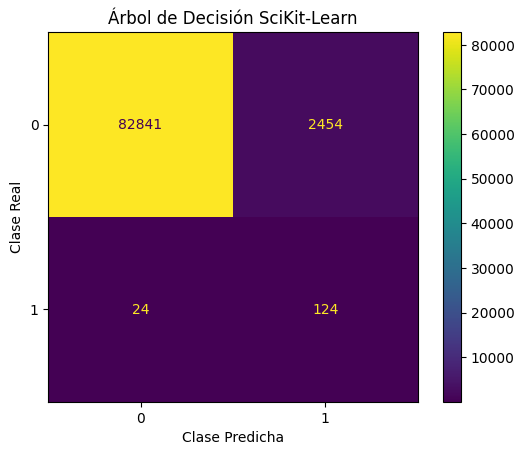

In [66]:
plot_confusion_matrix(y_test, pred_skl_dt, labels=labels, model_name="Árbol de Decisión SciKit-Learn")

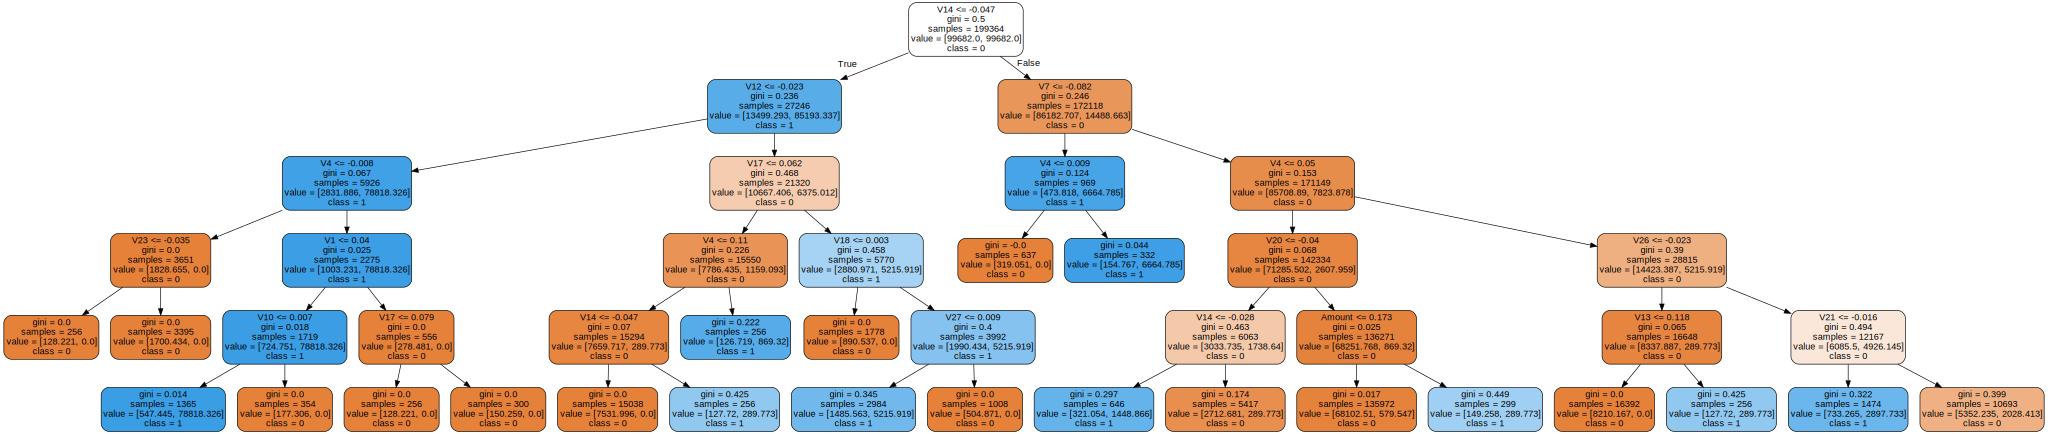

In [33]:
from sklearn.tree import export_graphviz
import graphviz

data_aux = data.drop(['Time','Class'], axis=1)
features = data_aux.columns
dot_data = export_graphviz(skl_dt, out_file = None, filled = True, rounded = True, class_names = ['0','1'], feature_names = features)
graph = graphviz.Source(dot_data)
graph

Arbol de Decision Snap ML

In [ ]:
pred_snapml_dt = snapml_dt.predict(X_test)
print("Reporte de Clasificacion: \n", classification_report(y_test, pred_snapml_dt))

Reporte de Clasificacion: 
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     85295
         1.0       0.07      0.82      0.13       148

    accuracy                           0.98     85443
   macro avg       0.54      0.90      0.56     85443
weighted avg       1.00      0.98      0.99     85443



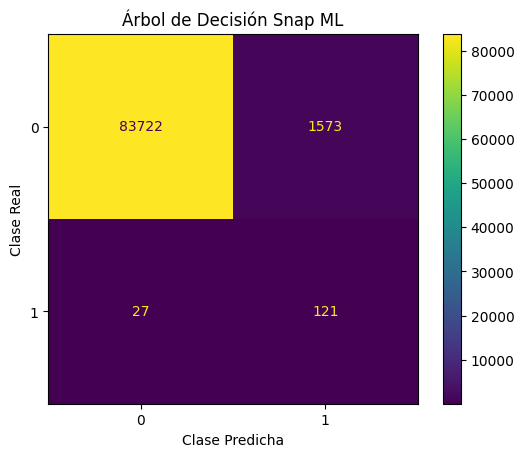

In [ ]:
plot_confusion_matrix(y_test, pred_snapml_dt, labels=labels, model_name="Árbol de Decisión Snap ML")

Snap ML no permite graficar el arbol de decision utilizando Graphviz como en el caso de SciKit-Learn